## DESI Throughput

The attached figure shows an estimate of the throughput derived from the fiber giving the highest throughput (presumably because closest to its target; this is fiber #307) on exposure #29181. Compared to simulations, we are still missing a factor 2.

This is very preliminary. Alternative analyses are more than welcome.
The spectra are there:
/project/projectdirs/desi/spectro/redux/daily/exposures/20191117/00029181/
(look at b3,r3,z3)
And the fiberassign file is here :
/project/projectdirs/desi/spectro/data/20191116/00028818/fiberassign-063064.fits
(several copies of the same file in different exposures)

In [1]:
import os
import numpy as np

In [2]:
import desispec.io
import desimodel.io
import desimodel.io

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='talk', style='ticks', font_scale=1.1)
%matplotlib inline

#### Find the data

In [4]:
datadir = os.getenv('DESI_ROOT')+'/spectro/data'
reduxdir = os.getenv('DESI_ROOT')+'/spectro/redux/daily/exposures'

In [5]:
bthru = desimodel.io.load_throughput('b')
rthru = desimodel.io.load_throughput('r')
zthru = desimodel.io.load_throughput('z')

In [6]:
night, expid = 20191117, 29181

In [7]:
def read_spec(cam='b', specid=3, night=20191117, expid=29181):
    strexpid = '{:08d}'.format(expid)
    specfile = os.path.join(reduxdir, str(night), strexpid, 'sframe-{}{:d}-{}.fits'.format(
        cam, specid, strexpid))
    print('Reading {}'.format(specfile))
    sr = desispec.io.read_frame(specfile)
    return sr

In [8]:
bcam, rcam, zcam = read_spec(cam='b'), read_spec(cam='r'), read_spec(cam='z')

Reading /global/project/projectdirs/desi/spectro/redux/daily/exposures/20191117/00029181/sframe-b3-00029181.fits
Reading /global/project/projectdirs/desi/spectro/redux/daily/exposures/20191117/00029181/sframe-r3-00029181.fits
Reading /global/project/projectdirs/desi/spectro/redux/daily/exposures/20191117/00029181/sframe-z3-00029181.fits


In [23]:
def plot_spec(bcam, rcam, zcam, fiberid=307):
    fig, ax = plt.subplots()
    #ax.plot(bcam.wave, bcam.flux[fiberid, :])
    #ax.plot(rcam.wave, rcam.flux[fiberid, :])
    #ax.plot(zcam.wave, zcam.flux[fiberid, :])
    
    ax.plot(bcam.wave, bthru.photons(bcam.wave, bcam.flux[fiberid, :]))

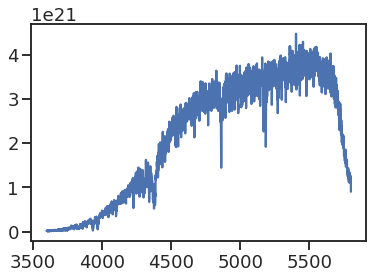

In [24]:
plot_spec(bcam, rcam, zcam, fiberid=307)

In [57]:
bcam.meta

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2751                                                  
NAXIS2  =                  500                                                  
EXTEND  =                    T                                                  
EXTNAME = 'FLUX    '                                                            
INSTRUME= 'DESI    '           / Instrument name                                
PROCTYPE= 'RAW     '           / Data processing level                          
PRODTYPE= 'image   '           / Data product type                              
PROGRAM = 'Dither tile_id 63064 (0.5,7.5)' / Program name                       
EXPID   =                29181 / Exposure number                                
EXPFRAME=                   

In [56]:
dir(bcam)

['R',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'chi2pix',
 'fibermap',
 'fibers',
 'flux',
 'ivar',
 'mask',
 'meta',
 'ndiag',
 'nspec',
 'nwave',
 'resolution_data',
 'scores',
 'scores_comments',
 'spectrograph',
 'vet',
 'wave',
 'wsigma']

In [53]:
def read_fibermap(night=20191116, expid=28818, fiberassignid=63064):
    strexpid = '{:08d}'.format(expid)
    strfiberassignid = '{:06d}'.format(fiberassignid)
                  
    fiberassignfile = os.path.join(datadir, str(night), strexpid, 'fiberassign-{}.fits'.format(
        strfiberassignid))
    sr = desispec.io.read_frame(specfile)
    return sr

In [11]:
dir(bthru)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_extinction',
 '_fiberinput',
 '_hc',
 '_throughput',
 '_thru',
 '_wave',
 'apply_throughput',
 'area',
 'atmospheric_throughput',
 'exptime',
 'extinction',
 'fiberarea',
 'fiberdia',
 'fiberinput_throughput',
 'hardware_throughput',
 'photons',
 'thru',
 'wavemax',
 'wavemin']

In [26]:
help(bthru.thru)

Help on method thru in module specter.throughput:

thru(*args, **kwargs) method of specter.throughput.Throughput instance
    same as calling self(*args, **kwargs)

